In [2]:
#relevant libraries for data inspection and analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency

#read in the dataset
movies = pd.read_csv('IMDB Top250 Movies.csv')
#print(movies.head())
#print(movies.info())

#cleaning dataset cast relevant columns as string in order to do string functions for cleaning
movies['Count of Ratings'] = movies['Count of Ratings'].astype(str)
movies['Budget'] = movies['Budget'].astype(str)
movies['Domestic Gross2'] = movies['Domestic Gross2'].astype(str)
movies['Domestic Weekend'] = movies['Domestic Weekend'].astype(str)
movies['Worldwide Gross'] = movies['Worldwide Gross'].astype(str)

#cleaning relevant columns and recasting as floats
movies['Count of Ratings'] = movies['Count of Ratings'].str.replace('K', '000').str.replace('M', '00000').str.replace('.', '', regex = True).astype(float)
movies['Budget'] = movies['Budget'].str.replace('\$', '', regex = True).str.replace('Not Found', 'NaN').str.replace('\(estimated\)', '', regex = True).str.replace(',', '', regex = True).astype(float)
movies['Domestic Gross2'] = movies['Domestic Gross2'].str.replace('\$', '', regex = True).str.replace(',', '', regex = True).str.replace('Not Found', 'NaN').astype(float)
movies['Domestic Weekend'] = movies['Domestic Weekend'].str.replace('\$', '', regex = True).str.replace(',', '', regex = True).str.replace('Not Found', 'NaN').astype(float)
movies['Worldwide Gross'] = movies['Worldwide Gross'].str.replace('\$', '', regex = True).str.replace(',', '', regex = True).str.replace('Not Found', 'NaN').astype(float)

#rename columns to make clear the values are dollar amounts
movies = movies.rename(columns = {'Budget':'Budget (estimated USD)', 'Domestic Gross2':'Domestic Gross2 (USD)', 'Domestic Weekend':'Domestic Weekend (USD)', 'Worldwide Gross':'Worldwide Gross (USD)'})

#drop null values from dataset
#for the purposes of analysis, budget and worldwide gross will be the relevant columns so null values for those columns only are dropped
movies.dropna(subset = ['Budget (estimated USD)', 'Worldwide Gross (USD)'], inplace = True)
movies.reset_index()

#create a new column titled Release Season noting season during which a movie released
#need to regex the release date column to isolate the month then create list for seasons, can then use function to check release date month and assign appropriate season
#regex on release date column to isolate release month
movies['Release Season'] = movies['Release Date'].str.replace(' \d\d?, \d{4} \(\w{5,6} \w{6,9}\)', '', regex = True).str.replace(' \d\d?, \d{4} \(\w{5,11}\)', '', regex = True)

#function to check season
def season_check(month):
    #create lists to compare release date column to
    winter = ['December', 'January', 'February']
    spring = ['March', 'April', 'May']
    summer = ['June', 'July', 'August']
    if month in winter:
        return 'Winter'
    elif month in spring:
        return 'Spring'
    elif month in summer:
        return 'Summer'
    else:
        return 'Fall'

#apply function to dataframe in order to get season of release for the movie
movies['Release Season'] = movies['Release Season'].apply(season_check)

#check dataframe column info and summary statistics
print(movies.info())
print(movies.describe(include = 'all'))

print(movies.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229 entries, 0 to 249
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Movies Names                 229 non-null    object 
 1   Rating out of 10             229 non-null    float64
 2   Count of Ratings             229 non-null    float64
 3   Genre                        229 non-null    object 
 4   Release Date                 229 non-null    object 
 5   Budget (estimated USD)       229 non-null    float64
 6   Domestic Gross               229 non-null    object 
 7   Domestic Gross2 (USD)        209 non-null    float64
 8   Domestic Weekend Gross       229 non-null    object 
 9   Domestic Weekend (USD)       189 non-null    float64
 10  Domestic Weekend Gross Date  229 non-null    object 
 11  Worldwide Gross (USD)        229 non-null    float64
 12  Release Season               229 non-null    object 
dtypes: float64(6), objec

In [11]:
genre_list = movies.Genre.unique()

genre_counts = movies.groupby('Genre').count()
print(genre_counts)

average_earnings = movies.groupby('Genre')['Worldwide Gross (USD)'].mean().round(2)
print(average_earnings)

budget = movies['Budget (estimated USD)']
earnings = movies['Worldwide Gross (USD)']


           Movies Names  Rating out of 10  Count of Ratings  Release Date  \
Genre                                                                       
Action               51                51                51            51   
Adventure            32                32                32            32   
Biography            20                20                20            20   
Comedy               23                23                23            23   
Crime                31                31                31            31   
Drama                63                63                63            63   
Horror                4                 4                 4             4   
Mystery               3                 3                 3             3   
Western               2                 2                 2             2   

           Budget (estimated USD)  Domestic Gross  Domestic Gross2 (USD)  \
Genre                                                                      


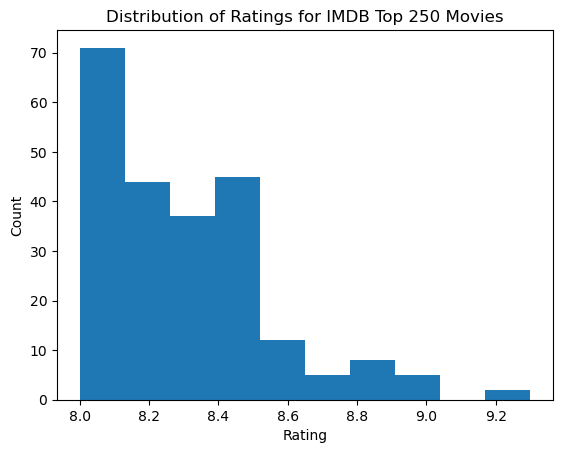

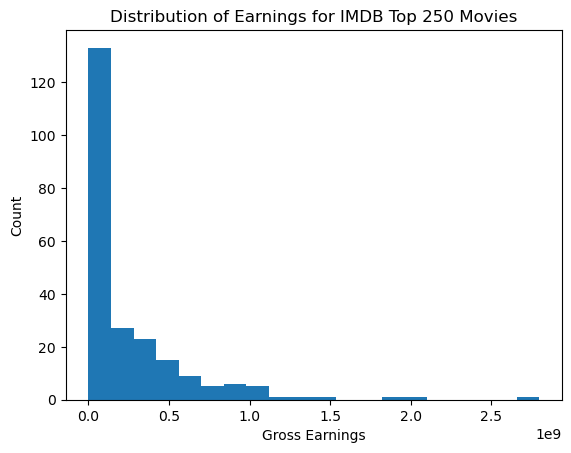

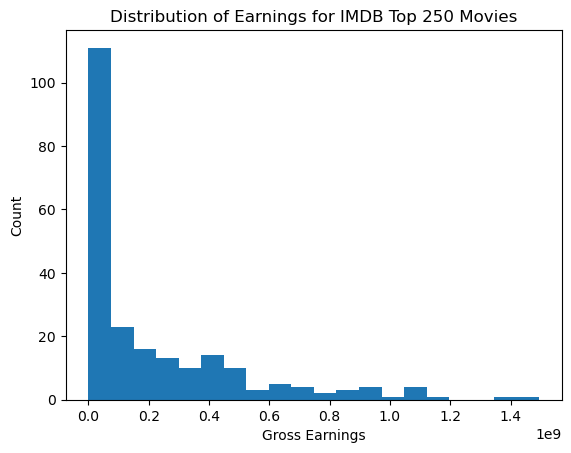

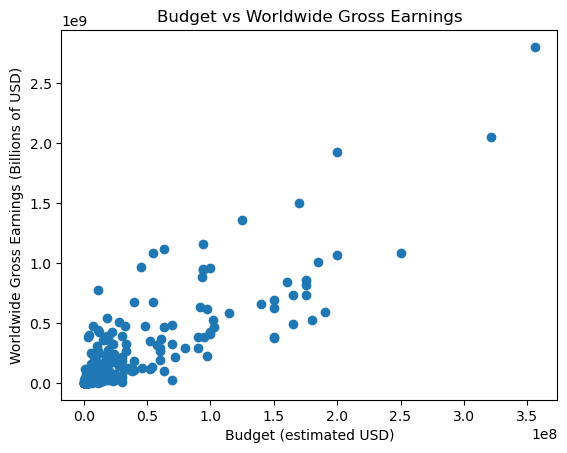

Correlation between budget and box office earnings: 0.8367099109645892


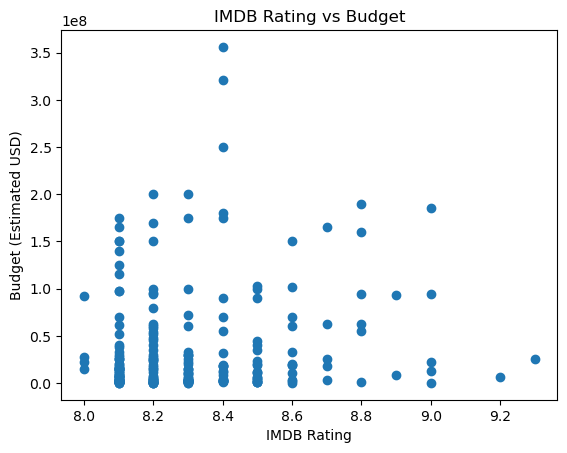

Correlation between IMDB rating and budget: 0.13275973882723097


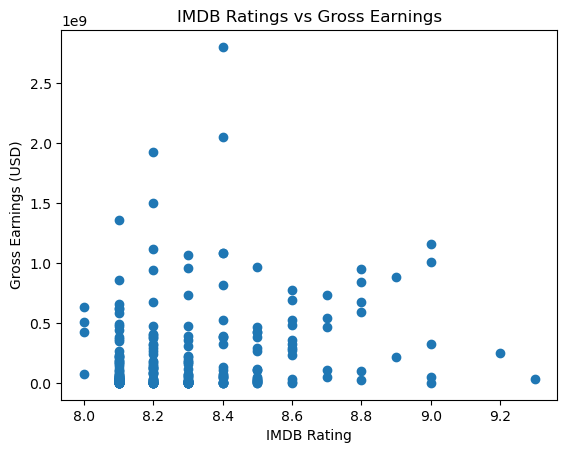

Correlation between IMDB rating and gross box office earnings: 0.17462423251175757


<Figure size 640x480 with 0 Axes>

In [10]:
#Analysis


plt.hist('Rating out of 10', data = movies)
plt.title('Distribution of Ratings for IMDB Top 250 Movies')
plt.ylabel('Count')
plt.xlabel('Rating')
plt.show()
plt.clf()
#distribution for ratings in the IMDB top 250 movies is right-skewed with most ratings falling between 8.0 and 8.4

plt.hist('Worldwide Gross (USD)', data = movies, bins = 20)
plt.title('Distribution of Earnings for IMDB Top 250 Movies')
plt.ylabel('Count')
plt.xlabel('Gross Earnings')
plt.show()
plt.clf()
#distribution for worldwide gross earnings in the IMDB top 250 movies

movies_no_outliers = movies.drop([63, 79, 171])

plt.hist('Worldwide Gross (USD)', data = movies_no_outliers, bins = 20)
plt.title('Distribution of Earnings for IMDB Top 250 Movies')
plt.ylabel('Count')
plt.xlabel('Gross Earnings')
plt.show()
plt.clf()

plt.scatter('Budget (estimated USD)', 'Worldwide Gross (USD)', data = movies)
plt.title('Budget vs Worldwide Gross Earnings')
plt.xlabel('Budget (estimated USD)')
plt.ylabel('Worldwide Gross Earnings (Billions of USD)')
plt.show()
plt.clf()
#scatter plot showing relationship between a movie's budget and the amount earned worldwide from screenings. 
#The graph shows a positive correlation between the variables, meaning the more money in a movie's budget the more likely it is to earn more in the box office.

corr_budget_gross, p = pearsonr(movies['Budget (estimated USD)'], movies['Worldwide Gross (USD)'])
print('Correlation between budget and box office earnings:', corr_budget_gross)
#checking correlation between budget and box office earnings indicates a very strong correlation with a value of 0.8367

plt.scatter('Rating out of 10', 'Budget (estimated USD)', data = movies)
plt.title('IMDB Rating vs Budget')
plt.xlabel('IMDB Rating')
plt.ylabel('Budget (Estimated USD)')
plt.show()
plt.clf()

corr_rating_budget, p = pearsonr(movies['Rating out of 10'], movies['Budget (estimated USD)'])
print('Correlation between IMDB rating and budget:', corr_rating_budget)

plt.scatter('Rating out of 10', 'Worldwide Gross (USD)', data = movies)
plt.title('IMDB Ratings vs Gross Earnings')
plt.xlabel('IMDB Rating')
plt.ylabel('Gross Earnings (USD)')
plt.show()
plt.clf()

corr_rating_gross, p = pearsonr(movies['Rating out of 10'], movies['Worldwide Gross (USD)'])
print('Correlation between IMDB rating and gross box office earnings:', corr_rating_gross)

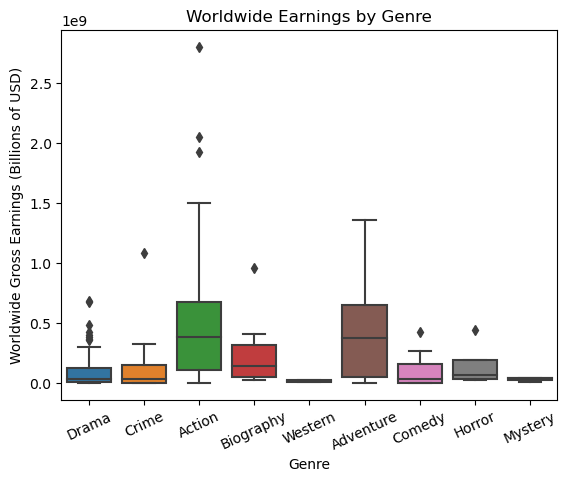

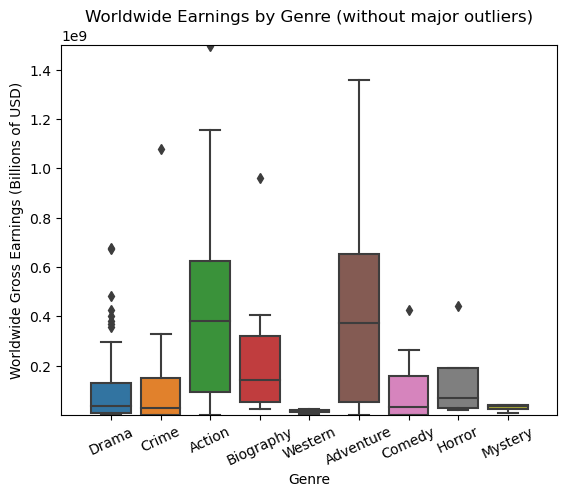

<Figure size 640x480 with 0 Axes>

In [6]:
sns.boxplot(data = movies, x = 'Genre', y = 'Worldwide Gross (USD)')
plt.xticks(range(9), genre_list, rotation = 25)
plt.ylabel('Worldwide Gross Earnings (Billions of USD)')
plt.title('Worldwide Earnings by Genre')
plt.show()
plt.clf()
#side by side boxplots in order to investigate if there is an impact of genre on how much money the movie will make in box office
#action and adventure films have a noticeably higher middle 50% of earnings when compared to other genres. This could be due to outliers in the case of the Action genre, with 4 films earning over $1 billion worldwide.
#in order to more easily compare the other genres, a dataframe excluding the outlier films (Avengers: Endgame, Avengers:Infinity War, Spiderman: No Way Home) was made and used for the creation of side by side boxplots
movies_no_outliers = movies.drop([63, 79, 171])

sns.boxplot(data = movies_no_outliers, x = 'Genre', y = 'Worldwide Gross (USD)')
plt.xticks(range(9), genre_list, rotation = 25)
plt.ylabel('Worldwide Gross Earnings (Billions of USD)')
plt.title('Worldwide Earnings by Genre (without major outliers)')
plt.axis([-1, 9, 1.0e+06, 1.5e+09])
plt.show()
plt.clf()
#when comparing boxplots now we can see that the Western genre does not make a wide range of money and does not make nearly as much as other genres, it seems that it is not as popular among general audiences and might not be a good investment.
#Mystery movies similarly do not make as much money as compared to other genres, and also do not make a wide range of money at the box office. Like-wise it might not be the best investment for production companies.
#Drama, Crime, Comedy, and Horror films are roughly equal in the range of money that they make with large overlap for their middle 50%, there is also a positive skew for these films (their median value is less than the average) indicating that even the worst box office performances for films in this genre tend to not to be complete flops and there is upside for exceptional box office performances.
#Biographical films tend to do better than all other genres with a higher median and upper range of their middle 50%, this boxplot is also positively skewed giving the same indications of a relatively high floor and potential for overperformance at the box office.
#Action and Adventure films clearly perform the best at box office, with middle 50% that sit almost entirely above those of the other genres, their plots are more symmetrical with little skew.
#The Action, Adventure, Western, and Mystery plots indicate an association between genre and worldwide grossings. However this could be attributed other factors than just the genre, 

#boxplot of budget by genre

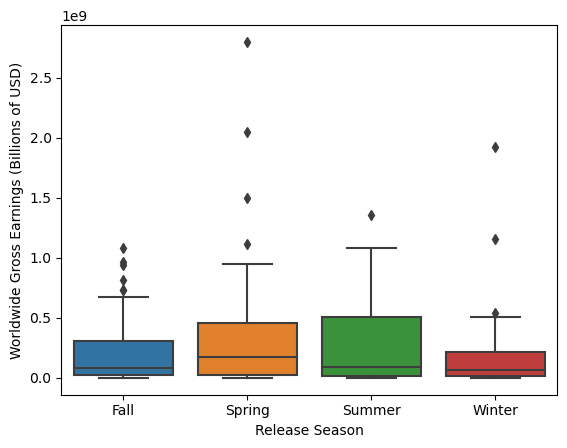

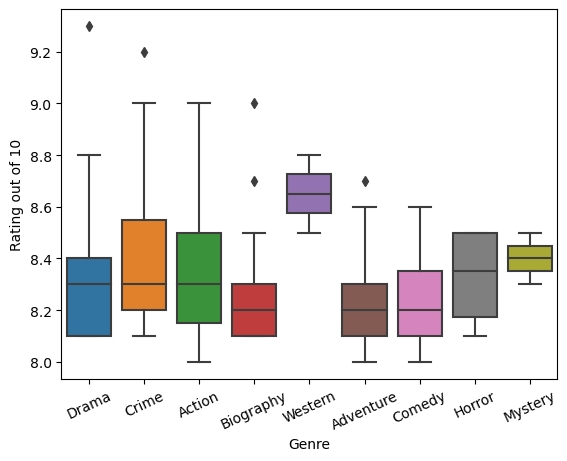

<Figure size 640x480 with 0 Axes>

In [7]:
sns.boxplot(data = movies, x = 'Release Season', y = 'Worldwide Gross (USD)')
plt.ylabel('Worldwide Gross Earnings (Billions of USD)')
plt.show()
plt.clf()
#side by side boxplots to investigate if the time of release impacts the earnings for a movie

sns.boxplot(data = movies, x = 'Genre', y = 'Rating out of 10')
plt.xticks(range(9), genre_list, rotation = 25)
plt.show()
plt.clf()

In [8]:
#compare ratings grouped by genre and see if the genre impacts audience rating

def rating_category(rating):
    #create categorical rating buckets
    very_good = [8.0, 8.1]
    great = [8.2, 8.3, 8.4]
    amazing = [8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3]
    
    if rating in very_good:
        return 'Very Good'
    if rating in great:
        return 'Great'
    if rating in amazing:
        return 'Amazing'
        

movies['Rating (Categorical)'] = movies['Rating out of 10'].apply(rating_category)

categorical_counts = movies.groupby(['Genre', 'Rating (Categorical)'])['Movies Names'].nunique().reset_index().pivot(columns = 'Rating (Categorical)',
                                                                                              index = 'Genre',
                                                                                              values = 'Movies Names')

categorical_counts.fillna(0, inplace = True)
print(categorical_counts)

contingency1 = [[14, 37], [3, 17]]
chi2_contingency(contingency1)


Rating (Categorical)  Amazing  Great  Very Good
Genre                                          
Action                   14.0   24.0       13.0
Adventure                 4.0   13.0       15.0
Biography                 3.0    8.0        9.0
Comedy                    3.0   11.0        9.0
Crime                    11.0   15.0        5.0
Drama                    13.0   31.0       19.0
Horror                    2.0    1.0        1.0
Mystery                   1.0    2.0        0.0
Western                   2.0    0.0        0.0


Chi2ContingencyResult(statistic=0.6348303537101119, pvalue=0.42558902443483737, dof=1, expected_freq=array([[12.21126761, 38.78873239],
       [ 4.78873239, 15.21126761]]))